In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import torch
from torch import nn

In [10]:
path = Path('../../data/results/experiment1')
ab = pd.read_csv(path/'dC_01.csv')['b'].values
#ab=[]

In [11]:
df = pd.read_csv(path/'best_known.csv')
best_known_fitness = df['fitness'].values
best_known_sumcv = df['sum_constraints'].values

In [12]:
D = 30
runs = 5
nn_window = 5
nn_nf = 4
frequency = 2_000
max_times =100 #len(ab)
total_generations = max_times * frequency + 1000

In [13]:
class SimpleModel(nn.Module):
    def __init__(self, d=D, w=nn_window, nf=nn_nf):
        super().__init__()
        self.fc1 = nn.Linear(d,nf)
        self.fc2 = nn.Linear(nf*w,d)
        self.act = nn.ReLU(inplace=True)
        
    def forward(self, x):
        fts = torch.cat([self.fc1(x[:,i]) for i in range(x.size(1))], dim=1)
        return self.fc2(self.act(fts))

model = SimpleModel()

In [14]:
nn_pick = 3 # how many individuals we predict
nn_window = 5 # time window used to predict next optimal

In [15]:
# Fitness functions

#  static function
def fitness_func(indiv, b, t): return (indiv.data**2).sum()

# experiment 3: dynamic fitness function (linear)
#def fitness_func(indiv, b, t): return ((indiv.data + 2*t)**2).sum()
# experiment 4: dynamic fitness function (sin)
#def fitness_func(indiv, b, t): return ((indiv.data-np.sin(np.pi/2*t))**2).sum()

# Constraints functions

# static or default
#def constraint_func(indiv, b, t): return -5 + sum((1/np.sqrt(D))*indiv.data)

# unconstrained
#def constraint_func(indiv, b, t): return 0


# Experiment 1 and 2: Dynamic constraint
def constraint_func(indiv, b, t): return -b[t] + sum((1/np.sqrt(D))*indiv.data)

Total time: 01:39
SpeedMetric(success rate): 0.5000
ModifiedOfflineError: 4.1071
OfflineError: 1.1599
AbsoluteRecoverRate: 1.2355


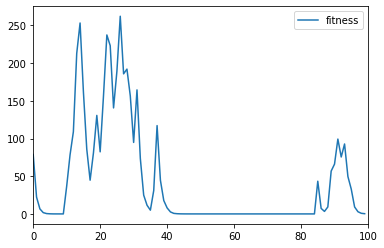

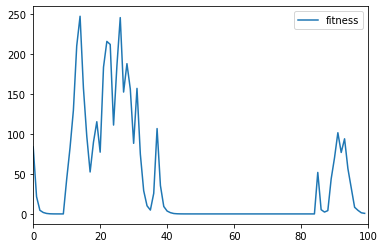

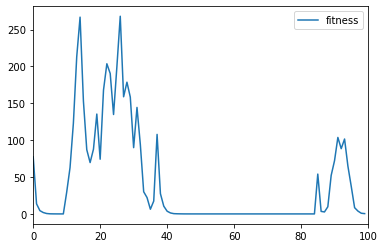

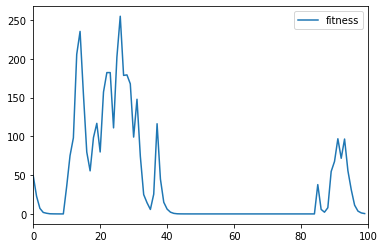

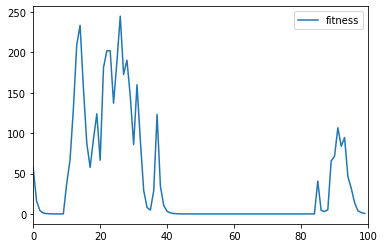

In [16]:
results = {'mof':[], 'sr':[], 'nfe':[], 'fitness':[], 'sumcv':[], 'arr':[]}

for run in range(runs):
    population = Population.new_random(dimension=D)
    nn_trainer = partial(NNTrainer, model=model, n=nn_pick, window=nn_window)

    speed_metric = partial(SpeedMetric, threadhold=0.2)

    opt = Optimization(population, fitness_func, constraint_func, constraint_params=[ab],
                       max_times=max_times, frequency=frequency, callbacks=[nn_trainer],
                       metrics=[speed_metric, ModifiedOfflineError, OfflineError, AbsoluteRecoverRate],
                       optimal_fitness_values=best_known_fitness, optimal_sum_constraints=best_known_sumcv)
    opt.state_dict
    opt.run(total_generations)
    # saving results
    results['mof'].append(opt.modified_offline_error.metrics)
    results['arr'].append(opt.absolute_recover_rate.metrics)
    results['sr'].append(opt.speed_metric.metrics)
    results['nfe'].append(opt.speed_metric.speeds)
    results['fitness'].append(opt.recorder.best_times_fitness)
    results['sumcv'].append(opt.recorder.best_times_constraints) 

In [17]:
df = pd.DataFrame({'fitness':opt.recorder.best_times_fitness, 'sum_constraints':opt.recorder.best_times_constraints})
df.head()

,fitness,sum_constraints
0,56.995024,0.0
1,15.981830,0.0
2,4.091404,0.0
3,1.085170,0.0
4,0.444350,0.0


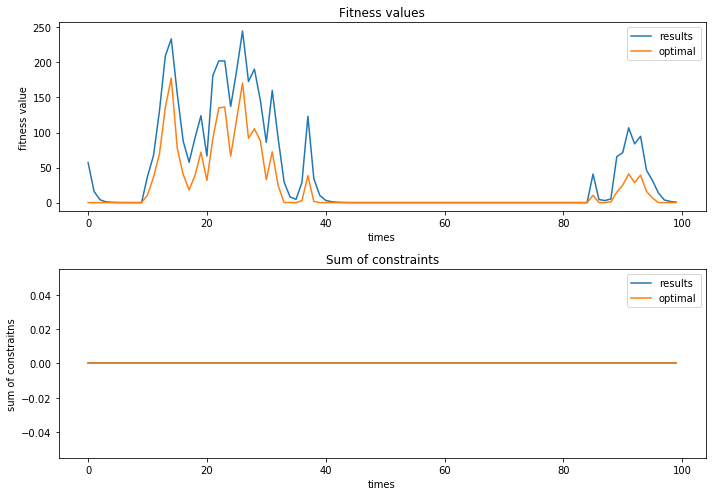

In [18]:
opt.recorder.plot();

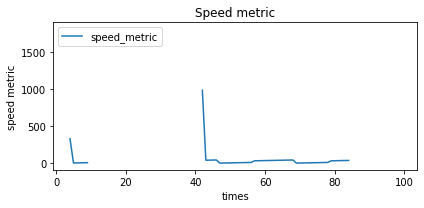

In [19]:
opt.recorder.plot_metrics();

In [20]:
#df.to_csv(path/'nn.csv', index=False)
pd.DataFrame({'mof':results['mof']}).to_csv(path/'nn_mof.csv', index=False)
pd.DataFrame({'sr':results['sr']}).to_csv(path/'nn_sr.csv', index=False)
pd.DataFrame(results['nfe']).to_csv(path/'nn_nfe.csv', index=False)
pd.DataFrame(results['fitness']).to_csv(path/'nn_fitness.csv', index=False)
pd.DataFrame(results['sumcv']).to_csv(path/'nn_sumcv.csv', index=False)
pd.DataFrame(results['arr']).to_csv(path/'nn_arr.csv', index=False)